## Using multiple strides in treadmill-acquired gait data for Multiple Sclerosis prediction 
### Vizualizing the predictions for best subject generalization model with the MS severity and balance scores 
* This analysis is only done on the predictions for the best subject gen model with the regress-N data
* Best subject gen model for regress-N data is Resnet 

### References:
FOR A BACKGROUND OF BOUNDARY IN SCATTER PLOT:
    - https://machinelearningmastery.com/plot-a-decision-surface-for-machine-learning/
    - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
    - https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_demo.html
    (Contourf and fill between functions)

FOR DIFFERENT SIZES OF BLOBS IN SCATTER PLOT:
    - https://stackoverflow.com/questions/47563373/plotting-circles-with-no-fill-colour-size-depending-on-variables-using-scatte
    - https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

FOR DIFFERENT SHADES OF A COLOR IN SCATTER PLOT:
    - https://stackoverflow.com/questions/64003816/how-to-plot-different-shades-of-a-color-for-each-point-in-a-scatter-plot-in-matp

FOR MARKING LABELS TO SIZES:
    - https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html

FOR HAVING 2 COLORBARS (ONE FOR GREEN SHADES AND ONE FOR RED SHADES) AND 2 DIFFERENT SHADES OF COLORS IN THE SAME SCATTERPLOT:
    - https://stackoverflow.com/questions/56080777/multiple-scatter-plots-with-two-colorbars


### Interpretation:
* HOAs with higher SPBB score (i.e. higher balance) are "more likely" to be correctly classified because their low frailty makes them an "easy group" to distinguish from the diseased with "potentially" higher frailty. Similarly, HOAs with a lower SPBB score or higher frailty are a "harder group" to distinguish from the MS/PD subjects, and thus, are "more likely" to be incorrectly classified.
* MS/PD on the other hand with higher SPBB score (i.e. higher balance) are "more likely" to behave like HOAs on our walking tasks and thus, are a "harder group" to differentiate from the HOAs. So, MS/PD subjects with higher SPBB are "more likely" to be incorrectly classified as HOA class. Similarly, MS/PD with lower SPBB score (i.e. lower balance) are "expected" to have distinguishing characteristics from HOAs, given their high frailty level, and thus are "more likely" to be an "easy group" to differentiate from HOAs and thus are "expected" to be correctly classified from the HOA class.

In [31]:
import sys
sys.path.append(r'D:\gait') #Because I am reading pickle file which is at a different folder

In [32]:
import torch
import torch.nn as nn
import numpy as np
import pickle
from torchinfo import summary
from utils.utils_lstm import read_data, genTTSequences, custom_StandardScaler
# %matplotlib widget
import matplotlib.pyplot as plt

import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.ticker as ticker
import seaborn as sns
from IPython import display
from matplotlib.lines import Line2D
import copy

In [33]:
#Path for the best subject gen model 
best_subject_model = 'D:\\gait\\results\\subject_generalize_lstm\\5strides\\all\\ResNet\\regressN\\BestSubjectProbs2021_05_23-17_50_21_339951\\'

#Dataframe with predictions for all subjects and their corresponding prediction prob.
prediction_df = pd.read_csv(best_subject_model + 'test_subject_true_predicted_labels.csv')
prediction_df.PID = prediction_df.PID.astype(int)
prediction_df['True Label'] = prediction_df['True Label'].astype(int)
prediction_df['Predicted Label'] = prediction_df['Predicted Label'].astype(int)
prediction_df = prediction_df.set_index('PID')
prediction_df.sort_index(inplace = True)

In [34]:
#Reading the EDSS for severity in PwMS (1 (lowest severity) - 6 (highest severity))
edss = pd.read_csv('D:\\gait\\data\\edss.csv')
#Reducing edss to only PIDs of interest
edss_reduced = edss[edss['PID'].isin(prediction_df.index)].set_index('PID')
edss_reduced.sort_index(inplace= True)

#Reading the overall balance scores for HOA and PwMS (6 (low balance) - 12 (higher balance))
balance_scores = pd.read_csv('D:\\gait\\data\\spppbplus.csv')
#Only keeping the overall score 
balance_scores = balance_scores[['Subject', 'Overall score']]
balance_scores.columns = ['PID', 'Overall balance score']
balance_scores_reduced = balance_scores[balance_scores['PID'].isin(prediction_df.index)].set_index('PID')
balance_scores_reduced.sort_index(inplace= True)

In [35]:
#Adding the corresponding EDSS and balance scores to the predictions dataframe 
prediction_df['edss'] = edss_reduced
prediction_df['balance_score'] = balance_scores_reduced

In [36]:
prediction_df_stacked = copy.deepcopy(prediction_df)

### SPPB plot with subject gen predictions 

In [ ]:
#Assigning the true label color 
prediction_df['color'] = 'g'
prediction_df['color'][prediction_df['True Label']==1] = 'r'

In [327]:
#Keeping all the predicted HOA first to fill up the green border and then all the predicted PwMS
#for the red border  
prediction_df.sort_values(by = ['Predicted Label', 'balance_score'], ascending = (True, True), 
                          inplace= True)

#Adding this sorted dataframe an index for sort 
prediction_df['index'] = range(1, len(prediction_df)+1)

In [328]:
#Basic statistics for the total SPPB scores 
print ('Min balance score = ', prediction_df['balance_score'].min())
print ('Max balance score = ', prediction_df['balance_score'].max())
print ('Mean, std balance score = ', prediction_df['balance_score'].mean(), prediction_df['balance_score'].std())

print ('FOR HOA: ')
print ('Min balance score = ', prediction_df[prediction_df['True Label']==0]['balance_score'].min())
print ('Max balance score = ', prediction_df[prediction_df['True Label']==0]['balance_score'].max())
print ('Mean, std balance score = ', prediction_df[prediction_df['True Label']==0]['balance_score'].mean(), prediction_df[prediction_df['True Label']==0]['balance_score'].std())

print ('FOR PwMS: ')
print ('Min balance score = ', prediction_df[prediction_df['True Label']==1]['balance_score'].min())
print ('Max balance score = ', prediction_df[prediction_df['True Label']==1]['balance_score'].max())
print ('Mean, std balance score = ', prediction_df[prediction_df['True Label']==1]['balance_score'].mean(), prediction_df[prediction_df['True Label']==1]['balance_score'].std())

print (prediction_df['True Label'].value_counts())
print (prediction_df['Predicted Label'].value_counts())

Min balance score =  6
Max balance score =  12
Mean, std balance score =  10.371428571428572 1.8484606359587632
FOR HOA: 
Min balance score =  8
Max balance score =  12
Mean, std balance score =  11.11111111111111 1.2313975269103983
FOR PwMS: 
Min balance score =  6
Max balance score =  12
Mean, std balance score =  9.588235294117647 2.0934070175616757
0    18
1    17
Name: True Label, dtype: int64
0    18
1    17
Name: Predicted Label, dtype: int64


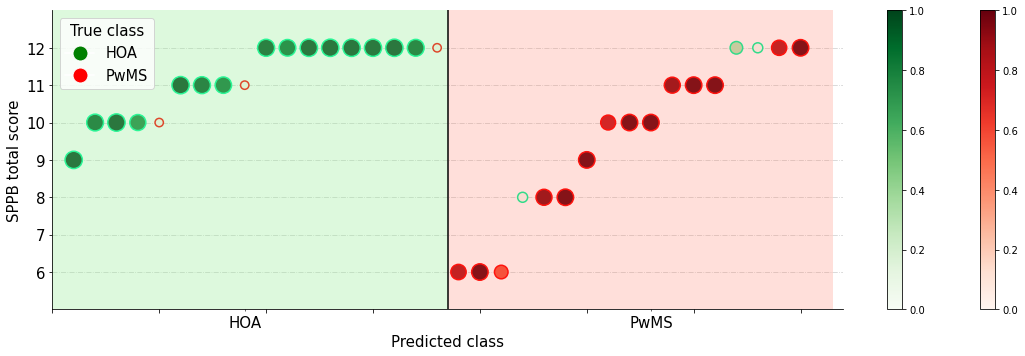

In [329]:
x = np.array(range(len(prediction_df['Predicted Label']))) + 1

y_upper_lim = prediction_df['balance_score'].max()+1
x_upper_lim = len(prediction_df['Predicted Label'])+2
x_lower_lim = 0

#Border color = Prediction space 
border = np.array(range(x_lower_lim, x_upper_lim)) + 0.5
border[0] = 0
borderline = 18.5

fig, ax = plt.subplots(figsize = (17.5, 5.5))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams['axes.axisbelow'] = True

scatter1 = ax.scatter(prediction_df[prediction_df['True Label']==0]['index'], \
                      prediction_df[prediction_df['True Label']==0]['balance_score'], \
                      c = prediction_df[prediction_df['True Label']==0]['correct'], \
                      s = 200*prediction_df[prediction_df['True Label']==0]['correct']+100, 
                      cmap = 'Greens', \
                      vmin = 0, vmax = 1, 
                      edgecolors='mediumspringgreen',
                     linewidths=1.5)
scatter2 = ax.scatter(prediction_df[prediction_df['True Label']==1]['index'], 
                      prediction_df[prediction_df['True Label']==1]['balance_score'], \
                    c = prediction_df[prediction_df['True Label']==1]['correct'], 
                    s = 200*prediction_df[prediction_df['True Label']==1]['correct']+70, 
                    cmap = 'Reds', 
                    vmin = 0,
                    vmax = 1,
                    edgecolors = 'red',
                     linewidths=1.5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='HOA',
                          markerfacecolor='g', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='PwMS',
                          markerfacecolor='r', markersize=15)]

plt.axvline(x = borderline, c='black')
ax.fill_between(border, y_upper_lim, where= border<=borderline,
                facecolor='lightgreen', alpha=0.3)
ax.fill_between(border, y_upper_lim, where= border>=borderline,
                facecolor='tomato', alpha=0.2)
plt.ylim([prediction_df['balance_score'].min()-1, y_upper_lim])
plt.xlim([x_lower_lim, x_upper_lim])
plt.yticks(range(prediction_df['balance_score'].min(), prediction_df['balance_score'].max()+1), fontsize = 15)
# produce a legend with the unique colors from the scatter
# p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
# ax.legend((p1, p2), ('HOA','PwMS'), loc='best', title = 'True class', fontsize = 15, title_fontsize = 16);
           
# Hide major tick labels
ax.xaxis.set_major_formatter(ticker.NullFormatter())

# Customize minor tick labels
ax.set_xticks([9, 28], minor=True)
ax.set_xticklabels(['HOA', 'PwMS'], minor=True, fontsize = 15)

ax.set_axisbelow(True)
plt.grid(True, axis = 'y', linestyle='-.', color = 'lightgrey')
ax.legend(handles=legend_elements, title = 'True class', fontsize = 14.5, title_fontsize = 15)

fig.colorbar(scatter2, ax=ax, fraction=.05, ticks = [0, 0.2, 0.4, 0.6, 0.8, 1])
fig.colorbar(scatter1, ax=ax, fraction=.05, ticks = [0, 0.2, 0.4, 0.6, 0.8, 1])


plt.xlabel('Predicted class', fontsize = 15)
plt.ylabel('SPPB total score', fontsize = 15)
# plt.savefig('C:Users\\Rachneet Kaur\\Box\\GaitLSTMproject\\severity_SPPB_sorted_by_balance_low_to_high.png', dpi = 300)
plt.savefig('D:\\gait\\results\\SubjectGen_SeverityPlots\\severity_SPPB_sorted_by_balance_low_to_high.png', dpi = 300)
plt.show()

### Version 2 of SPPB plot with predictions 

In [38]:
#We need green = prob HOA = 1, red = Prof HOA = 0/Prob MS = 1, so we will be using insider color of 
#the shape as the prediction probability of healthy class 
prediction_df_stacked['prob_HOA'] = 1- prediction_df_stacked['prob_class1']

In [40]:
#Assigning a new column which tells whether this PID was correctly predicted or not
prediction_df_stacked['correct_label'] = (prediction_df_stacked['True Label']==prediction_df_stacked['Predicted Label'])

In [41]:
prediction_df_stacked

,correct,True Label,Predicted Label,prob_class1,edss,balance_score,edgecolor,shape,prob_HOA,correct_label
PID,,,,,,,,,,
200,0.951220,0,0,0.048780,NaN,12,g,o,0.951220,True
201,0.878788,0,0,0.121212,NaN,12,g,o,0.878788,True
202,0.289474,0,1,0.710526,NaN,12,g,o,0.289474,False
203,1.000000,0,0,0.000000,NaN,11,g,o,1.000000,True
204,1.000000,0,0,0.000000,NaN,12,g,o,1.000000,True
205,0.000000,0,1,1.000000,NaN,12,g,o,0.000000,False
206,0.934783,0,0,0.065217,NaN,11,g,o,0.934783,True
207,1.000000,0,0,0.000000,NaN,12,g,o,1.000000,True
208,0.911111,0,0,0.088889,NaN,10,g,o,0.911111,True


In [43]:
#Sorting first by SPPB, then by predicted label (HOA then MS), then if correctly classified or not and 
#with what probability 
prediction_df_stacked.sort_values(by = ['balance_score', 'Predicted Label', 'correct'], \
                                  ascending = (True, True, False), inplace = True)

In [45]:
prediction_df_stacked['y_axis'] = 1

In [47]:
#Assigning the y axis 
balance_score = prediction_df_stacked['balance_score'].iloc[0]
predicted = prediction_df_stacked['Predicted Label'].iloc[0]
y_axis = 1
for idx in range(1, len(prediction_df_stacked)):
    if ((prediction_df_stacked['balance_score'].iloc[idx] == balance_score) & (prediction_df_stacked['Predicted Label'].iloc[idx] == predicted)):
        y_axis+=1
        prediction_df_stacked['y_axis'].iloc[idx]=y_axis
    else:
        y_axis = 1
        prediction_df_stacked['y_axis'].iloc[idx]=y_axis
        balance_score = prediction_df_stacked['balance_score'].iloc[idx]
        predicted = prediction_df_stacked['Predicted Label'].iloc[idx]
            

In [287]:
#Assigning the x-axis 
prediction_df_stacked['x_axis'] = [1, 1, 1, 3, 3, 3, 4.2, 4.8, 6.2, 6.2, 6.2, 6.2, 6.8, 6.8, 6.8, 8.2, 8.2, 8.2, 8.2, 8.8, 8.8, 8.8] + 9*[10.2] + 4*[10.8]

In [288]:
prediction_df_stacked

,correct,True Label,Predicted Label,prob_class1,edss,balance_score,edgecolor,shape,prob_HOA,correct_label,y_axis,x_axis
PID,,,,,,,,,,,,
318,1.000000,1,1,1.000000,6.0,6,red,s,0.000000,True,1,1.0
307,0.823529,1,1,0.823529,6.0,6,red,s,0.176471,True,2,1.0
321,0.571429,1,1,0.571429,6.0,6,red,s,0.428571,True,3,1.0
322,1.000000,1,1,1.000000,6.0,8,red,s,0.000000,True,1,3.0
313,0.928571,1,1,0.928571,6.0,8,red,s,0.071429,True,2,3.0
219,0.000000,0,1,1.000000,NaN,8,mediumspringgreen,o,0.000000,False,3,3.0
216,1.000000,0,0,0.000000,NaN,9,mediumspringgreen,o,1.000000,True,1,4.2
300,1.000000,1,1,1.000000,6.0,9,red,s,0.000000,True,1,4.8
214,1.000000,0,0,0.000000,NaN,10,mediumspringgreen,o,1.000000,True,1,6.2


### Plotting 

In [289]:
marker_HOA = 'o'
marker_MS = 's'

edgecolor_HOA = 'mediumspringgreen'
edgecolor_MS = 'red'
#Assigning the edge color and shape of the marker as the true label color 
prediction_df_stacked['edgecolor'] = edgecolor_HOA
prediction_df_stacked['edgecolor'][prediction_df_stacked['True Label']==1] = edgecolor_MS

prediction_df_stacked['shape'] = marker_HOA
prediction_df_stacked['shape'][prediction_df_stacked['True Label']==1] = marker_MS

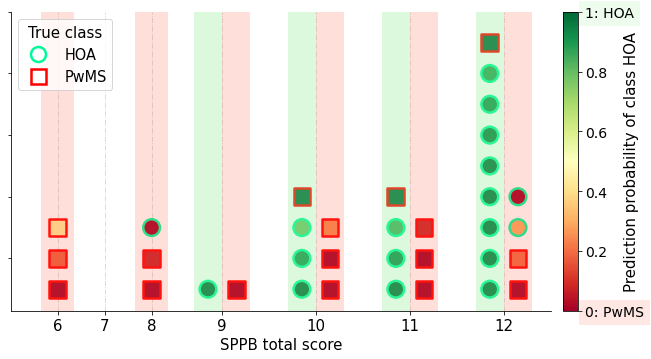

In [314]:
#Plotting stacked 
#We will use cmap RdYlGn 
font = {'size'   : 15}

fig, ax = plt.subplots(figsize = (11, 5.5))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams['axes.axisbelow'] = True

scatter1 = ax.scatter(prediction_df_stacked[prediction_df_stacked['True Label']==0]['x_axis'], \
                      prediction_df_stacked[prediction_df_stacked['True Label']==0]['y_axis'], \
                      c = prediction_df_stacked[prediction_df_stacked['True Label']==0]['prob_HOA'], \
                      s = 280,
                      marker = marker_HOA,
                      edgecolors =  prediction_df_stacked[prediction_df_stacked['True Label']==0]['edgecolor'],\
                      linewidths = 2.5,
                      cmap = 'RdYlGn', \
                      vmin = 0, vmax = 1, 
#                       edgecolors='mediumspringgreen',
#                      linewidths=1.5
                     )
scatter2 = ax.scatter(prediction_df_stacked[prediction_df_stacked['True Label']==1]['x_axis'], \
                      prediction_df_stacked[prediction_df_stacked['True Label']==1]['y_axis'], \
                      c = prediction_df_stacked[prediction_df_stacked['True Label']==1]['prob_HOA'], \
                      s = 280,
                      marker = marker_MS,
                      edgecolors =  prediction_df_stacked[prediction_df_stacked['True Label']==1]['edgecolor'],\
                      linewidths = 2.5,
                      cmap = 'RdYlGn', \
                      vmin = 0, vmax = 1, 
#                       edgecolors='mediumspringgreen',
#                      linewidths=1.5
                     )
legend_elements = [Line2D([0], [0], marker= marker_HOA, markeredgecolor= edgecolor_HOA, label='HOA',
                          markerfacecolor='w', markersize=15, linestyle = 'None', markeredgewidth = 2.5),
                  Line2D([0], [0], marker=marker_MS, markeredgecolor=edgecolor_MS, label='PwMS',
                          markerfacecolor='w', markersize=15, linestyle = 'None', markeredgewidth = 2.5)]

plt.grid(True, axis = 'x', linestyle='-.', color = 'lightgrey')
ax.legend(handles=legend_elements, title = 'True class', fontsize = 14.5, title_fontsize = 15)

cb = fig.colorbar(scatter1, ax=ax, fraction=.1, ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], pad = 0.02)
cb.set_label(label='Prediction probability of class HOA',fontdict=font, labelpad = -20.0, rotation = 90)
cb.set_ticklabels(['0: PwMS', '0.2', '0.4', '0.6', '0.8', '1: HOA'])
cb.ax.get_yticklabels()[0].set_bbox(dict(facecolor="tomato", alpha=0.15, edgecolor = "None"))
cb.ax.get_yticklabels()[5].set_bbox(dict(facecolor="lightgreen", alpha=0.15, edgecolor = "None"))
cb.ax.tick_params(labelsize=14)

border = np.arange(0, 3, 0.05) + 0.4
ax.fill_between(border, 10, where= (border>=0.65) & (border<=1.35),
                facecolor='tomato', alpha=0.2)
border = np.arange(2, 4, 0.05)
ax.fill_between(border, 10, where= (border>=2.6) & (border<=3.35),
                facecolor='tomato', alpha=0.2)
border = np.arange(3, 15, 0.1)
ax.fill_between(border, 10, where= (border>=3.9) & (border<=4.6),
                facecolor='lightgreen', alpha=0.3)
ax.fill_between(border, 10, where= (border>=4.5) & (border<=5.2),
                facecolor='tomato', alpha=0.2)
ax.fill_between(border, 10, where= (border>=5.9) & (border<=6.6),
                facecolor='lightgreen', alpha=0.3)
ax.fill_between(border, 10, where= (border>=6.5) & (border<=7.2),
                facecolor='tomato', alpha=0.2)
ax.fill_between(border, 10, where= (border>=7.9) & (border<=8.6),
                facecolor='lightgreen', alpha=0.3)
ax.fill_between(border, 10, where= (border>=8.5) & (border<=9.2),
                facecolor='tomato', alpha=0.2)
ax.fill_between(border, 10, where= (border>=9.9) & (border<=10.6),
                facecolor='lightgreen', alpha=0.3)
ax.fill_between(border, 10, where= (border>=10.5) & (border<=11.2),
                facecolor='tomato', alpha=0.2)

ax.set_axisbelow(True)
plt.ylim([0.3, 10])
plt.xlim([0, 11.5])

plt.yticks(fontsize = 15)
# produce a legend with the unique colors from the scatter
# p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
# ax.legend((p1, p2), ('HOA','PwMS'), loc='best', title = 'True class', fontsize = 15, title_fontsize = 16);
           
# Hide major tick labels
# ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_formatter(ticker.NullFormatter())

# Customize minor tick labels
ax.set_xticks([1, 2, 3, 4.5, 6.5, 8.5, 10.5])
ax.set_xticklabels([6, 7, 8, 9, 10, 11, 12], fontsize = 15)


plt.xlabel('SPPB total score', fontsize = 15)
# plt.savefig('C:\\Users\\Rachneet Kaur\\Box\\GaitLSTMproject\\severity_SPPB_sorted_by_balance_low_to_high.png', dpi = 300)
plt.savefig('D:\\gait\\results\\SubjectGen_SeverityPlots\\severity_SPPB_stacked.png', dpi = 300)
plt.show()

### EDSS plot with predictions of the best subject gen model 

In [89]:
#Keeping all the predicted HOA first to fill up the green border and then all the predicted PwMS
#for the red border  
prediction_df_edss = prediction_df.dropna()
prediction_df_edss.sort_values(by = ['Predicted Label', 'edss'], ascending = (True, True), 
                          inplace= True)

#Adding this sorted dataframe an index for sort 
prediction_df_edss['index'] = range(1, len(prediction_df_edss)+1)

In [334]:
#Basic statistics for the total SPPB scores 
print ('Min EDSS score = ', prediction_df_edss['edss'].min())
print ('Max EDSS score = ', prediction_df_edss['edss'].max())
print ('Mean, std EDSS score = ', prediction_df_edss['edss'].mean(), prediction_df_edss['edss'].std())

print ('FOR HOA: ')
print ('Min EDSS score = ', prediction_df_edss[prediction_df_edss['True Label']==0]['edss'].min())
print ('Max EDSS score = ', prediction_df_edss[prediction_df_edss['True Label']==0]['edss'].max())
print ('Mean, std EDSS score = ', prediction_df_edss[prediction_df_edss['True Label']==0]['edss'].mean(), prediction_df_edss[prediction_df_edss['True Label']==0]['edss'].std())

print ('FOR PwMS: ')
print ('Min EDSS score = ', prediction_df_edss[prediction_df_edss['True Label']==1]['edss'].min())
print ('Max EDSS score = ', prediction_df_edss[prediction_df_edss['True Label']==1]['edss'].max())
print ('Mean, std EDSS score = ', prediction_df_edss[prediction_df_edss['True Label']==1]['edss'].mean(), prediction_df_edss[prediction_df_edss['True Label']==1]['edss'].std())

print (prediction_df_edss['True Label'].value_counts())
print (prediction_df_edss['Predicted Label'].value_counts())

Min EDSS score =  1.0
Max EDSS score =  6.0
Mean, std EDSS score =  4.235294117647059 1.7331117882549398
FOR HOA: 
Min EDSS score =  nan
Max EDSS score =  nan
Mean, std EDSS score =  nan nan
FOR PwMS: 
Min EDSS score =  1.0
Max EDSS score =  6.0
Mean, std EDSS score =  4.235294117647059 1.7331117882549398
1    17
Name: True Label, dtype: int64
1    14
0     3
Name: Predicted Label, dtype: int64


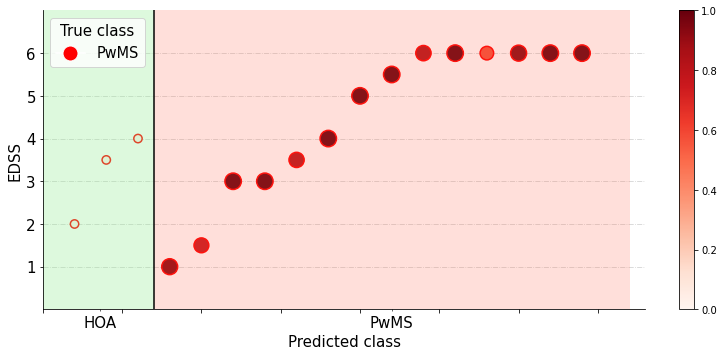

In [335]:
x = np.array(range(len(prediction_df_edss['Predicted Label']))) + 1

y_upper_lim = prediction_df_edss['edss'].max()+1
x_upper_lim = len(prediction_df_edss['Predicted Label'])+2
x_lower_lim = 0

#Border color = Prediction space 
border = np.array(range(x_lower_lim, x_upper_lim)) + 0.5
border[0] = 0
borderline = 3.5

fig, ax = plt.subplots(figsize = (12, 5.5))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams['axes.axisbelow'] = True

scatter2 = ax.scatter(prediction_df_edss[prediction_df_edss['True Label']==1]['index'], 
                      prediction_df_edss[prediction_df_edss['True Label']==1]['edss'], \
                    c = prediction_df_edss[prediction_df_edss['True Label']==1]['correct'], 
                    s = 200*prediction_df_edss[prediction_df_edss['True Label']==1]['correct']+70, 
                    cmap = 'Reds', 
                    vmin = 0,
                    vmax = 1,
                    edgecolors = 'red',
                     linewidths=1.5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='PwMS',
                          markerfacecolor='r', markersize=15)]

plt.axvline(x = borderline, c='black')
ax.fill_between(border, y_upper_lim, where= border<=borderline,
                facecolor='lightgreen', alpha=0.3)
ax.fill_between(border, y_upper_lim, where= border>=borderline,
                facecolor='tomato', alpha=0.2)
plt.ylim([prediction_df_edss['edss'].min()-1, y_upper_lim])
plt.xlim([x_lower_lim, x_upper_lim])
plt.yticks(np.arange(prediction_df_edss['edss'].min(), prediction_df_edss['edss'].max()+1), fontsize = 15)
         
# Hide major tick labels
ax.xaxis.set_major_formatter(ticker.NullFormatter())

# Customize minor tick labels
ax.set_xticks([1.8, 11], minor=True)
ax.set_xticklabels(['HOA', 'PwMS'], minor=True, fontsize = 15)

ax.set_axisbelow(True)
plt.grid(True, axis = 'y', linestyle='-.', color = 'lightgrey')
ax.legend(handles=legend_elements, title = 'True class', fontsize = 14.5, title_fontsize = 15)

fig.colorbar(scatter2, ax=ax, fraction=.05, ticks = [0, 0.2, 0.4, 0.6, 0.8, 1])

plt.xlabel('Predicted class', fontsize = 15)
plt.ylabel('EDSS', fontsize = 15)
# plt.savefig('severity_EDSS_sorted_by_edss_high_to_low.png', dpi = 300)
plt.savefig('D:\\gait\\results\\SubjectGen_SeverityPlots\\severity_EDSS_sorted_by_balance_low_to_high.png', dpi = 300)
plt.show()